# Importing

In [67]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [ ]:
import pandas as pd


columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt', 
                 sep='\t',
                 usecols=columns)

df.head()

In [2]:
df["Central Air"] = df['Central Air'].map({'Y':1,'N':0})

df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [3]:
df = df.dropna(axis = 0)
print(df.isnull().sum())

df.head()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64


,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,1,1656,215000
1,5,6,882.0,1,896,105000
2,6,6,1329.0,1,1329,172000
3,7,5,2110.0,1,2110,244000
4,5,5,928.0,1,1629,189900


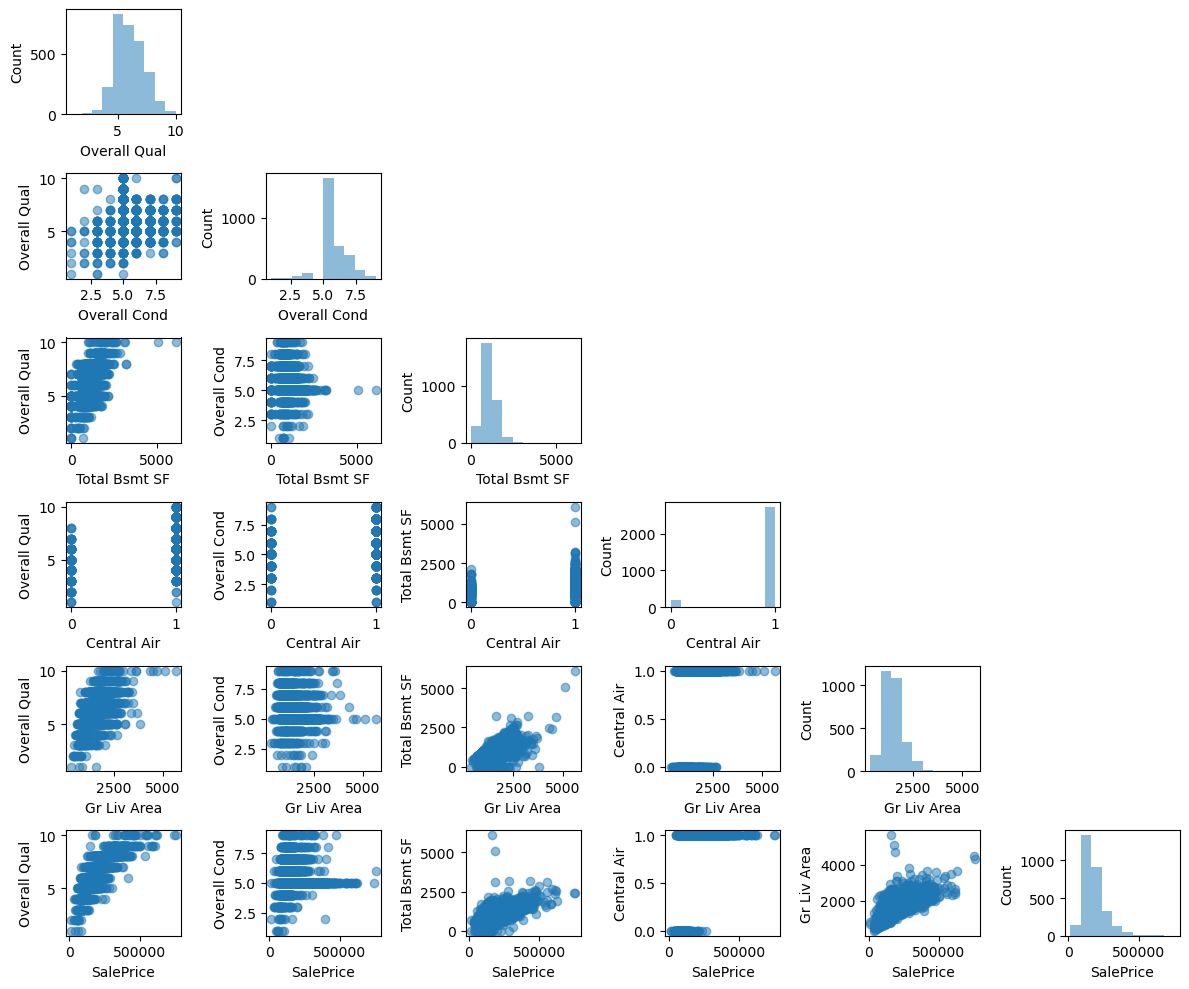

In [6]:
scatterplotmatrix(df.values,figsize = (12,10),names = df.columns, alpha=0.5)
plt.tight_layout()
plt.show()

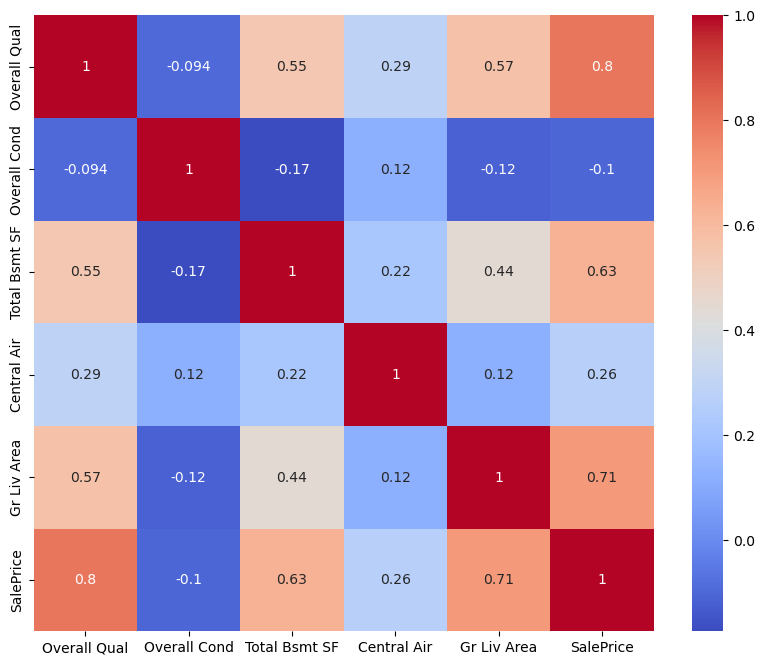

In [12]:
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap = 'coolwarm')
plt.show()

## Linear Regression function

In [34]:
class LinearRegressionGD:
    def __init__(self, eta = 0.1, n_iter = 50, random_state = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, x,y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0,scale = 0.1,size = x.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []
            
        for i in range(self.n_iter):
            output = self.net_input(x)
            errors = y - output
            self.w_ += self.eta * 2.0 * x.T.dot(errors) / x.shape[0]
            self.b_ = self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
        
    def net_input(self,x):
        return np.dot(x,self.w_) + self.b_
        
    def predict(self, x):
        return self.net_input(x)

In [35]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [36]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

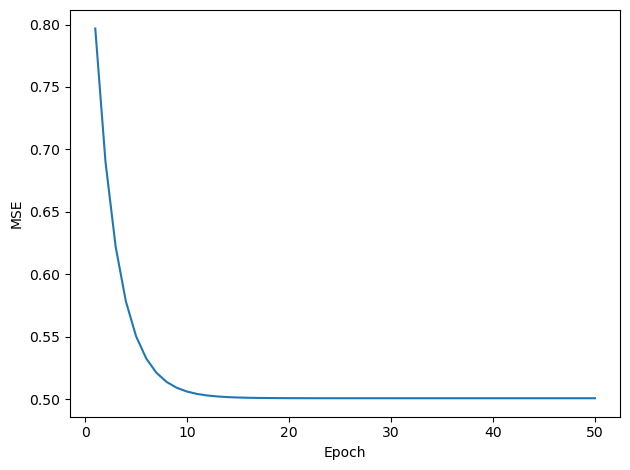

In [37]:
plt.plot(range(1,lr.n_iter + 1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [43]:
def lin_regplot(x,y,model):
    plt.scatter(x,y,c='steelblue',edgecolor='white',s=70,alpha = 0.75)
    plt.plot(x,model.predict(x),color='black',lw=2)
    return

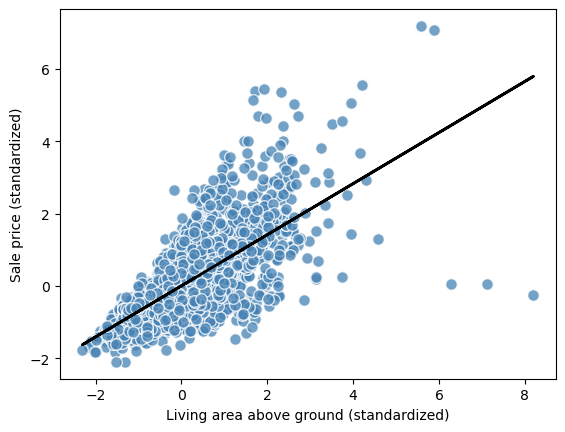

In [45]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')
plt.show()

In [46]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sale price: ${target_reverted.flatten()[0]:.2f}')

Sale price: $292507.40


In [51]:
slr = LinearRegression()
slr.fit(X,y)
y_pred = slr.predict(X)

print(f'Slope: {slr.coef_[0].round(3)}')
print(f'Intercept: {slr.intercept_.round(3)}')

Slope: 111.666
Intercept: 13342.979


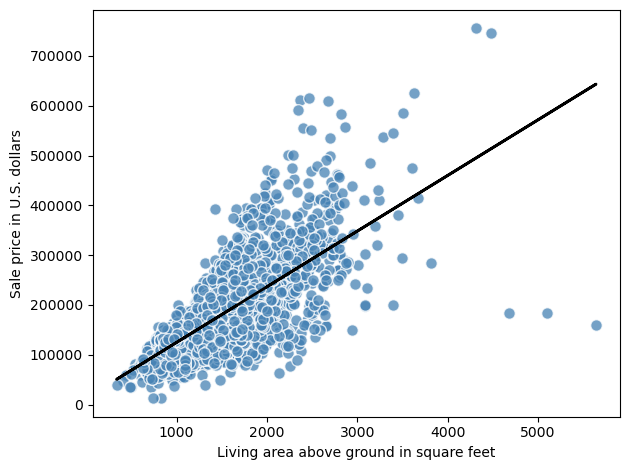

In [52]:
lin_regplot(X,y,slr)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.tight_layout()
plt.show()

## RANSAC

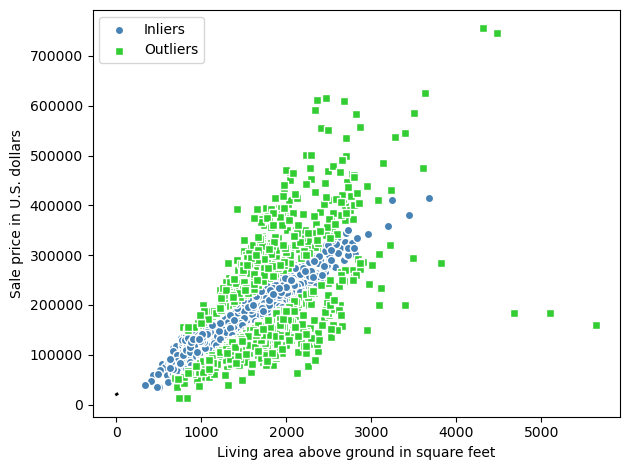

Slope: 106.348
Intercept: 20190.093


In [57]:
ransac = RANSACRegressor(LinearRegression(),
                        max_trials = 100,
                        min_samples = 0.95,
                        loss = 'absolute_error', # default,
                        residual_threshold=None,
                        random_state=123)

ransac.fit(X,y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
#plot inliers
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
#plot outliers
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')

plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

In [58]:
def median_abs_deviation(data):
    return np.median(np.abs(data - np.median(data)))

median_abs_deviation(y)

37000.0

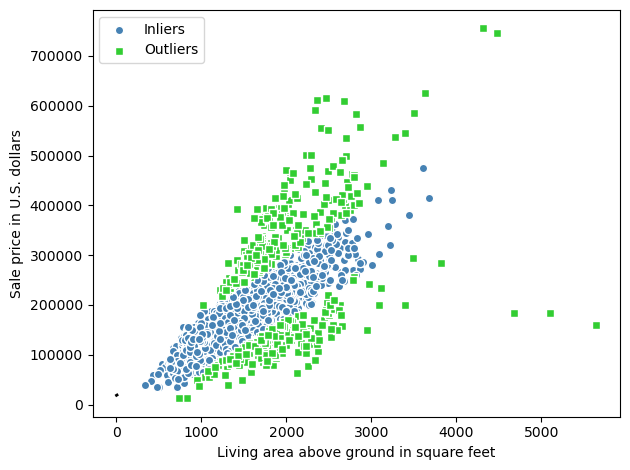

In [60]:
# MODEL WITH HIGHER RESIDUAL THRESHOLD
ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, # default
                         min_samples=0.95, 
                         loss='absolute_error', # default
                         residual_threshold=65000, # default 
                         random_state=123)

ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('figures/09_10.png', dpi=300)
plt.show()

# Evaluating the performance of linear regression models

In [62]:
target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

In [63]:
slr = LinearRegression()

slr.fit(X_train,y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

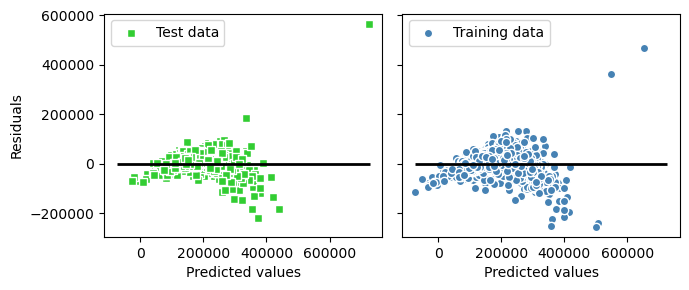

In [64]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

#plt.savefig('figures/09_11.png', dpi=300)
plt.show()

## MSE

In [66]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


## MAE

In [68]:
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25983.03
MAE test: 24921.29


## R^2

In [69]:
r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

R^2 train: 0.77
R^2 test: 0.75
